
Geschäftsszenario Ein Einzelhandelsunternehmen möchte seine Kunden in Gruppen unterteilen, um für jede Gruppe geeignete Marketingstrategien zu entwickeln. Zu diesem Zweck werden die bisherigen Einkaufsgewohnheiten der Kunden analysiert und Kunden mit ähnlichen Merkmalen in Segmente eingeteilt.

Innformationen zum Datensatz Der Datensatz enthält das frühere Einkaufsverhalten von Kunden, die in bestimmten Jahren sowohl online als auch offline eingekauft haben:

| Merkmal                 | Beschreibung                                                              |
|-------------------------|---------------------------------------------------------------------------|
| `cust_id`               | Eindeutige Kundennummer                                                   |
| `purchase_channel`      | Bestellkanal (z. B. Android, iOS, Desktop, Mobile)                         |
| `recent_channel`        | Kanal der letzten Bestellung                                              |
| `first_purchase_date`   | Datum des ersten Einkaufs                                                 |
| `last_purchase_date`    | Datum des letzten Einkaufs                                                |
| `last_online_date`      | Datum des letzten Online-Einkaufs                                         |
| `last_offline_date`     | Datum des letzten Offline-Einkaufs                                        |
| `num_orders_online`     | Gesamtanzahl der Online-Bestellungen                                      |
| `num_orders_offline`    | Gesamtanzahl der Offline-Bestellungen                                     |
| `spend_offline_total`   | Gesamtbetrag der Offline-Einkäufe                                         |
| `spend_online_total`    | Gesamtbetrag der Online-Einkäufe                                          |
| `categories_last12`     | Kategorien, in denen in den letzten 12 Monaten eingekauft wurde           |

In [3]:
#!pip install yellowbrick
#!pip install xgboost
#!pip install lightgbm
#!pip install gmpy2
#!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings

import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
warnings.simplefilter(action='ignore', category=Warning)        #um zu warning vermeiden

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [7]:
df= pd.read_csv("X_data.csv")

In [8]:
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,"f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"69b69676-1a40-11ea-941b-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1854e56c-491f-11eb-806e-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


In [9]:
"""
with open("X_data.csv", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if line.count(",") != 11:  # 12 sütun için 11 virgül olmalı
            print(f"Satır {i} bozuk: {line}")
"""


'\nwith open("X_data.csv", "r", encoding="utf-8") as f:\n    for i, line in enumerate(f):\n        if line.count(",") != 11:  # 12 sütun için 11 virgül olmalı\n            print(f"Satır {i} bozuk: {line}")\n'

In [10]:
with open("X_data.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()


In [ ]:
cleaned_rows = []
for line in lines:
    parts = line.strip().split(",")
    
    # Zusätzliches Komma in der ersten Zelle bei Bedarf entfernen
    if len(parts) > 12:
        cust_id = parts[0]
        purchase_channel = parts[1]
        recent_channel = parts[2]
        rest = parts[3:]
        fixed_row = [cust_id, purchase_channel, recent_channel] + rest
        cleaned_rows.append(fixed_row[:12])  # Überflüssige Spalten entfernen
    elif len(parts) == 12:
        cleaned_rows.append(parts)


In [ ]:
columns = ["cust_id", "purchase_channel", "recent_channel", "first_purchase_date", "last_purchase_date",
           "last_online_date", "last_offline_date", "num_orders_online", "num_orders_offline",
           "spend_offline_total", "spend_online_total", "categories_last12"]

df = pd.DataFrame(cleaned_rows[1:], columns=columns)  # [1:] Header-Zeilen identifizieren


In [13]:
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"""""[ERKEK"
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"""""[ERKEK"
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"""""[AKTIFCOCUK"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [14]:
df.shape

(19945, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cust_id              19945 non-null  object
 1   purchase_channel     19945 non-null  object
 2   recent_channel       19945 non-null  object
 3   first_purchase_date  19945 non-null  object
 4   last_purchase_date   19945 non-null  object
 5   last_online_date     19945 non-null  object
 6   last_offline_date    19945 non-null  object
 7   num_orders_online    19945 non-null  object
 8   num_orders_offline   19945 non-null  object
 9   spend_offline_total  19945 non-null  object
 10  spend_online_total   19945 non-null  object
 11  categories_last12    19945 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


In [16]:
df.columns

Index(['cust_id', 'purchase_channel', 'recent_channel', 'first_purchase_date', 'last_purchase_date', 'last_online_date', 'last_offline_date', 'num_orders_online', 'num_orders_offline', 'spend_offline_total', 'spend_online_total', 'categories_last12'], dtype='object')

In [ ]:
# Numerische Spalten in das Float- Format konvertieren
numeric_columns = ['num_orders_online', 'num_orders_offline', 'spend_offline_total', 'spend_online_total']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders_online,19945.000,3.111,4.226,1.000,1.000,2.000,4.000,200.000
num_orders_offline,19945.000,1.914,2.063,1.000,1.000,1.000,2.000,109.000
spend_offline_total,19945.000,253.923,301.533,10.000,99.990,179.980,319.970,18119.140
spend_online_total,19945.000,497.322,832.602,12.990,149.980,286.460,578.440,45220.130


In [ ]:
# Datums- Spalte in Datetime konvertieren
date_columns = ['first_purchase_date', 'last_purchase_date', 'last_online_date', 'last_offline_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [ ]:
# Aufgrund veralteter Daten wurde das letzte Kaufdatum als Referenz verwendet
today = df["last_purchase_date"].max() + pd.Timedelta(days=1)

In [ ]:
# Tenure: Kundenbeziehungsdauer
df['Tenure'] = (today - df['first_purchase_date']).dt.days

# Recency: Tage seit letztem Kauf
df['Recency'] = (today - df['last_purchase_date']).dt.days

# Frequency: Gesamtanzahl der Bestellungen
df['Frequency'] = df['num_orders_online'] + df['num_orders_offline']

# Monetary: Monetärer Gesamtbetrag
df['Monetary'] = df['spend_online_total'] + df['spend_offline_total']

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cust_id              19945 non-null  object        
 1   purchase_channel     19945 non-null  object        
 2   recent_channel       19945 non-null  object        
 3   first_purchase_date  19945 non-null  datetime64[ns]
 4   last_purchase_date   19945 non-null  datetime64[ns]
 5   last_online_date     19945 non-null  datetime64[ns]
 6   last_offline_date    19945 non-null  datetime64[ns]
 7   num_orders_online    19945 non-null  float64       
 8   num_orders_offline   19945 non-null  float64       
 9   spend_offline_total  19945 non-null  float64       
 10  spend_online_total   19945 non-null  float64       
 11  categories_last12    19945 non-null  object        
 12  Tenure               19945 non-null  int64         
 13  Recency              19945 non-

#### Auswahl numerischer Merkmale für die Segmentierung

In [23]:
features = list(filter(lambda col: df[col].dtype in ['int64', 'float64'], df.columns))
print(features)

['num_orders_online', 'num_orders_offline', 'spend_offline_total', 'spend_online_total', 'Tenure', 'Recency', 'Frequency', 'Monetary']


#### Standardisierung der Variablen

In [24]:
features= df[features].copy()

# Standardizasyon
sc = MinMaxScaler((0,1))
df_scaled = sc.fit_transform(features)
df_scaled[0:5]


array([[0.01507538, 0.        , 0.00717814, 0.01739526, 0.06841244,
        0.25479452, 0.015     , 0.01950257],
       [0.09045226, 0.00925926, 0.00828145, 0.04071459, 0.51358429,
        0.28219178, 0.095     , 0.04292553],
       [0.01005025, 0.00925926, 0.00993808, 0.00845796, 0.17905074,
        0.50410959, 0.015     , 0.01178235],
       [0.        , 0.        , 0.00165607, 0.00152609, 0.04615385,
        0.36438356, 0.        , 0.0016788 ],
       [0.        , 0.        , 0.00220828, 0.0032517 , 0.21702128,
        0.23013699, 0.        , 0.0035979 ]])

#### Bestimmung der optimalen Clusteranzahl (Elbow-Methode)

In [ ]:
kmeans= KMeans(random_state= 42, n_init=10)

In [26]:
ssd= []

K=range(1,30)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_scaled)
    ssd.append(kmeans.inertia_)

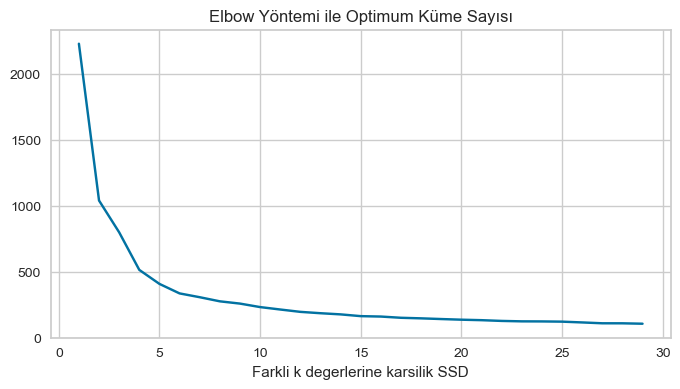

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(K, ssd, "bx-")
plt.xlabel('SSD-Werte in Abhängigkeit von der Clusteranzahl k')
plt.title('Clusteranzahl mit der Elbow-Methode')
plt.grid(True)
plt.show()


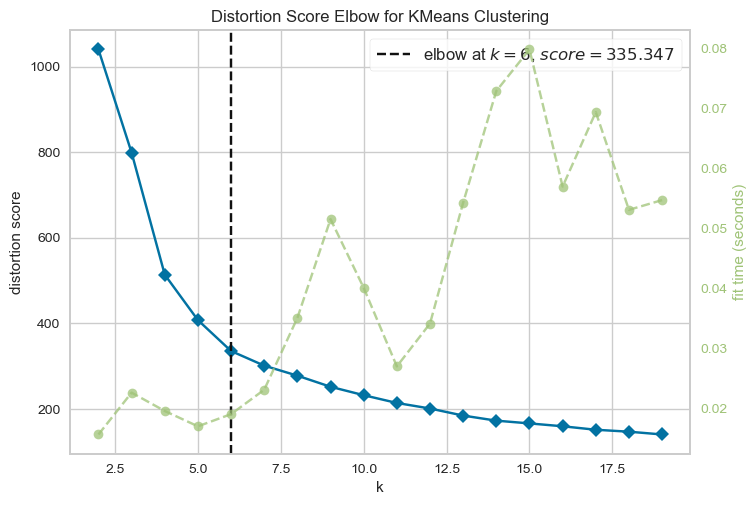

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Bestimmung der optimalen Clusteranzahl mit der Elbow-Methode
elbow= KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(df_scaled)
elbow.show()

In [29]:
print("Optimale Anzahl der Cluster:", elbow.elbow_value_)

Optimale Anzahl der Cluster: 6


#### Segmentierung mit K-Means

In [30]:
kmeans_final= KMeans(n_clusters=elbow.elbow_value_, random_state=42, n_init=10).fit(df_scaled)
clusters_kmeans= kmeans_final.labels_

In [31]:
#Fügen wir die Segmente der Original Dataframe hinzu
df['kmeans_cluster_no']= clusters_kmeans +1  #Es soll bei 1 beginnen

In [32]:
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,Tenure,Recency,Frequency,Monetary,kmeans_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],213,94,5.000,939.370,2
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"""""[ERKEK",1573,104,21.000,2013.550,1
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"""""[ERKEK",551,185,5.000,585.320,4
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"""""[AKTIFCOCUK",145,134,2.000,121.970,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],667,85,2.000,209.980,2


#### Jedes Segment statistisch auswerten

In [ ]:
df_summary = df.groupby('kmeans_cluster_no').agg({'cust_id': 'nunique', **{col: ['count', 'mean', 'median'] for col in features}})
#** multiindex

In [34]:
df_summary.head()

cust_id num_orders_online              num_orders_offline              spend_offline_total                 spend_online_total                  Tenure                   Recency                 Frequency              Monetary                 
                  nunique             count  mean median              count  mean median               count    mean  median              count     mean  median  count     mean   median   count    mean  median     count  mean median    count     mean  median
kmeans_cluster_no                                                                                                                                                                                                                                                 
1                    1663              1663 7.527  5.000               1663 2.150  2.000                1663 287.426 202.200               1663 1041.824 584.370   1663 1880.042 1806.000    1663  70.422  69.000      1663 9.676  7.000     1663 1329.250 913.440
2                    4627              4627 2.442  2.000               4627 1.965  1.000                4627 258.039 180.480               4627  398.922 246.970   4627  613.789  614.000    4627 109.354 108.000      4627 4.407  4.000     4627  656.961 504.230
3                     997               997 5.274  3.000                997 1.925  1.000                 997 250.200 174.980                997  650.851 370.960    997 2001.221 1979.000     997 260.715 257.000       997 7.199  5.000      997  901.051 660.880
4                    3923              3923 2.355  2.000               3923 1.768  1.000                3923 231.894 165.710               3923  396.687 257.970   3923  665.921  632.000    3923 200.279 196.000      3923 4.123  3.000     3923  628.581 485.930
5                    2535              2535 2.056  1.000               2535 1.751  1.000                2535 217.895 150.730               2535  331.373 219.980   2535  704.034  652.000    2535 318.280 322.000      2535 3.807  3.000     2535  549.267 442.930

## Kundensegmentierung mit hierarchischem Clustering

In [35]:
hc_average= linkage(df_scaled, method='average')

#### Bestimmung der Anzahl der Cluster

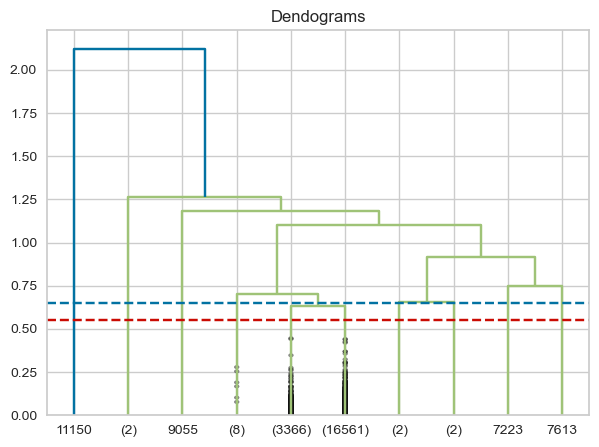

In [ ]:
#Dendrogramm, reduziert auf die letzten 10 Cluster-Zusammenführungen
plt.figure(figsize=(7,5))
plt.title("Dendograms")
dend= dendrogram(hc_average, 
                truncate_mode="lastp",
                p=10,
                show_contracted=True,
                leaf_font_size=10)
plt.axhline(y=0.55, color='r', linestyle='--')
plt.axhline(y=0.65, color='b', linestyle='--')
plt.show()

#### Final Modal

In [37]:
cluster=AgglomerativeClustering(n_clusters=10, linkage="average")
clusters= cluster.fit_predict(df_scaled)

In [38]:
df["hi_cluster_no"] = clusters +1

In [39]:
df.head(5)

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,Tenure,Recency,Frequency,Monetary,kmeans_cluster_no,hi_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],213,94,5.000,939.370,2,3
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"""""[ERKEK",1573,104,21.000,2013.550,1,3
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"""""[ERKEK",551,185,5.000,585.320,4,3
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"""""[AKTIFCOCUK",145,134,2.000,121.970,2,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],667,85,2.000,209.980,2,3


In [ ]:
hi_summary = df.groupby('hi_cluster_no').agg({'cust_id': 'nunique', **{col: ['count', 'mean', 'median'] for col in features}})
#** multiindex

In [41]:
hi_summary= hi_summary.round(1)
hi_summary.head()

cust_id num_orders_online               num_orders_offline               spend_offline_total                   spend_online_total                     Tenure                 Recency                 Frequency               Monetary                    
              nunique             count   mean median              count   mean median               count     mean   median              count      mean    median  count    mean  median   count    mean  median     count   mean median    count      mean    median
hi_cluster_no                                                                                                                                                                                                                                                          
1                   2                 2 38.500 38.500                  2  1.000  1.000                   2  334.700  334.700                  2 33688.100 33688.100      2 560.000 560.000       2  72.500  72.500         2 39.500 39.500        2 34022.800 34022.800
2                3366              3366  2.500  2.000               3366  1.800  1.000                3366  219.700  159.700               3366   370.700   230.000   3366 907.600 703.000    3366 310.100 316.000      3366  4.300  3.000     3366   590.400   460.000
3               16561             16561  3.200  2.000              16561  1.900  1.000               16561  256.700  180.700              16561   511.400   300.000  16561 778.100 640.000   16561  97.600  86.000     16561  5.100  4.000    16561   768.200   567.900
4                   2                 2 67.500 67.500                  2  2.500  2.500                   2  463.100  463.100                  2 17218.000 17218.000      2 976.000 976.000       2  39.500  39.500         2 70.000 70.000        2 17681.100 17681.100
5                   8                 8  4.200  2.500                  8 53.100 46.000                   8 4163.800 3868.200                  8   813.500   393.000      8 868.600 835.500       8  78.400  82.000         8 57.400 50.000        8  4977.300  4498.600

#### Mit Warddendogram

In [42]:
hc_ward= linkage(df_scaled, method='ward')

endgültiger Verbindungsabstand: [15.02788695804092, 47.138785705312806, 47.138785705312806, 23.330650730742327]


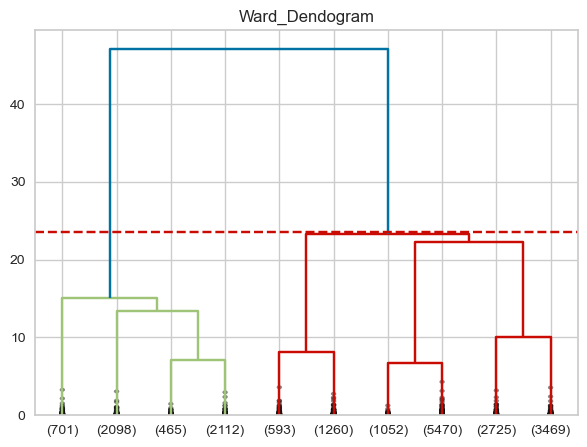

In [43]:
plt.figure(figsize=(7,5))
plt.title("Ward_Dendogram")
dend= dendrogram(hc_ward, 
                truncate_mode="lastp",
                p=10,
                show_contracted=True,
                leaf_font_size=10)

last_merge= dend['dcoord'][-1]
print("endgültiger Verbindungsabstand:", last_merge)
plt.axhline(y=last_merge[1]*0.5, color='r', linestyle='--')
plt.show()

## Ward Final Modal

In [44]:
cluster=AgglomerativeClustering(n_clusters=10, linkage="ward")
clusters= cluster.fit_predict(df_scaled)

In [45]:
df["hi_clusterward_no"] = clusters +1

In [46]:
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12,Tenure,Recency,Frequency,Monetary,kmeans_cluster_no,hi_cluster_no,hi_clusterward_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],213,94,5.000,939.370,2,3,7
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"""""[ERKEK",1573,104,21.000,2013.550,1,3,1
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"""""[ERKEK",551,185,5.000,585.320,4,3,3
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"""""[AKTIFCOCUK",145,134,2.000,121.970,2,3,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],667,85,2.000,209.980,2,3,7


In [ ]:
hi_summary = df.groupby('hi_clusterward_no').agg({'cust_id': 'nunique', **{col: ['count', 'mean', 'median'] for col in features}})
#** multiindex 

In [49]:
hi_summary= hi_summary.round(1)
hi_summary.head(10)

cust_id num_orders_online              num_orders_offline              spend_offline_total                 spend_online_total                  Tenure                   Recency                 Frequency               Monetary                 
                  nunique             count  mean median              count  mean median               count    mean  median              count     mean  median  count     mean   median   count    mean  median     count   mean median    count     mean  median
hi_clusterward_no                                                                                                                                                                                                                                                  
1                    1260              1260 6.700  4.000               1260 2.100  2.000                1260 284.600 200.800               1260  935.100 552.000   1260 1554.500 1533.500    1260  77.900  81.000      1260  8.900  7.000     1260 1219.700 889.600
2                     701               701 5.100  3.000                701 1.900  1.000                 701 262.300 180.000                701  617.100 333.000    701 2094.800 2150.000     701 282.500 295.000       701  7.000  5.000      701  879.400 643.900
3                    3469              3469 2.100  1.000               3469 1.700  1.000                3469 228.800 166.000               3469  363.400 240.000   3469  563.800  574.000    3469 163.500 162.000      3469  3.800  3.000     3469  592.200 464.900
4                    2112              2112 2.300  2.000               2112 1.800  1.000                2112 228.100 160.800               2112  373.300 257.300   2112  723.800  753.000    2112 234.300 237.000      2112  4.100  3.000     2112  601.400 485.000
5                    5470              5470 3.300  2.000               5470 2.100  2.000                5470 272.800 190.900               5470  566.900 350.200   5470  687.300  645.000    5470  34.000  30.000      5470  5.400  4.000     5470  839.700 628.400
6                    2098              2098 2.000  1.000               2098 1.700  1.000                2098 212.300 150.500               2098  326.400 220.000   2098  697.400  641.000    2098 327.700 329.000      2098  3.700  3.000     2098  538.700 442.900
7                    2725              2725 2.200  1.000               2725 2.100  1.000                2725 287.400 190.000               2725  367.400 233.700   2725  548.300  571.000    2725  96.800  98.000      2725  4.400  3.000     2725  654.800 490.700
8                     593               593 7.800  5.000                593 2.100  2.000                 593 281.700 201.000                593 1137.000 541.400    593 2423.500 2366.000     593  83.500  80.000       593 10.000  7.000      593 1418.600 821.900
9                     465               465 5.600  4.000                465 1.900  1.000                 465 237.500 170.000                465  798.700 580.900    465 1448.600 1454.000     465 200.200 197.000       465  7.500  6.000      465 1036.100 794.400
10                   1052              1052 2.200  1.000               1052 1.400  1.000                1052 235.900 170.800               1052  405.900 272.500   1052  212.100  202.000    1052  22.600  21.000      1052  3.600  3.000     1052  641.800 499.900

In [50]:
crosstab= pd.crosstab(df['hi_clusterward_no'], df['kmeans_cluster_no'])

#Normalization: Zeilen je Hierarchieebene in % umwandeln
crosstab_normalized= crosstab.div(crosstab.sum(axis=1), axis=0)

#Stärkste Überrinstimmungen finden
best_matches= crosstab_normalized.idxmax(axis=1)
best_ratios= crosstab_normalized.max(axis=1)

match_summary= pd.DataFrame({'Hierarchic Cluster': best_matches.index,
                             'Meistübereinstimmend KMeans Cluster': best_matches.values,
                             'Anteil': (best_ratios*100).round(2).astype(str) + '%'})

print(match_summary)

                   Hierarchic Cluster  Meistübereinstimmend KMeans Cluster  Anteil
hi_clusterward_no                                                                 
1                                   1                                    1  81.27%
2                                   2                                    3  96.15%
3                                   3                                    4  58.63%
4                                   4                                    4  78.22%
5                                   5                                    6  90.29%
6                                   6                                    5  99.86%
7                                   7                                    2  92.95%
8                                   8                                    1  90.22%
9                                   9                                    4  48.39%
10                                 10                                    6  100.0%


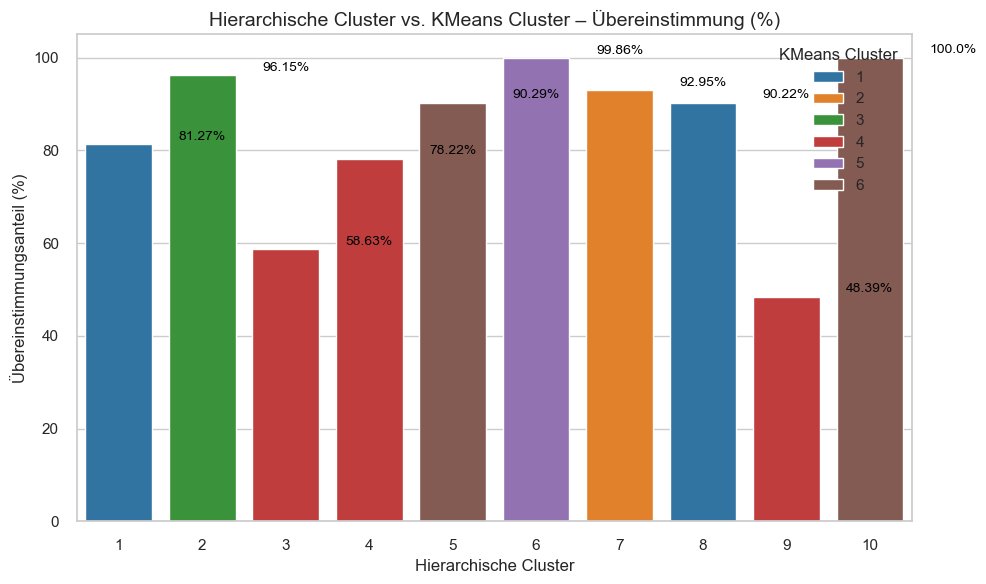

In [ ]:

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Hierarchic Cluster',
    y=match_summary['Anteil'].str.replace('%', '').astype(float),
    hue='Meistübereinstimmend KMeans Cluster',
    data=match_summary,
    palette='tab10')

plt.title('Hierarchische Cluster vs. KMeans Cluster – Übereinstimmung (%)', fontsize=13)
plt.xlabel('Hierarchische Cluster', fontsize=12)
plt.ylabel('Übereinstimmungsanteil (%)', fontsize=12)


for i, row in match_summary.iterrows():
    ax.text(
        i,
        float(row['Anteil'].replace('%', '')) + 1,
        row['Anteil'],
        color='black',
        ha='center',
        fontsize=10
    )

plt.legend(title='KMeans Cluster')
plt.tight_layout()
plt.show()
